If running locally run the following command first, it will install all necessary requirements to ensure no dependency errors. If viewing as HTML or PDF, you can ignore this.


In [1]:
# If running locally run the following command:
# %pip install -r requirements.txt

# Section 1: Data Cleaning


## Import datasets into project and join by shared columns


In [2]:
# Import OS for accesing system folders
import os as os

# Import Pandas for conversion of .csv into dataframes and usage of Pandas library
import pandas as pd
import numpy as np

In [3]:
# Set folder_path from our current directory
folder_path = os.getcwd()

# Update folder_path to Data/ folder to access .csv files
folder_path = os.path.join(folder_path, r"Data")

In [4]:
# Check that the files needed are in the folder
os.listdir(folder_path)

['2012_cleaned.csv', '2013_cleaned.csv', '2014_cleaned.csv']

### Our first issue with these tables is that not all of them possess the same columns (only the names are the same). Therefore, we need to extract only the columns that all three tables have in common to avoid problems when merging into a bigger dataframe.


In [5]:
# Proof: columns are different for each .csv

# Loop through each file by name of files as in:
# ['2012_cleaned.csv', '2013_cleaned.csv', '2014_cleaned.csv']
for file_name in os.listdir(folder_path):
    current_file_path = os.path.join(folder_path, file_name)
    current_df = pd.read_csv(
        current_file_path
    )  # Convert the current .csv into a df to use Pandas columns() module
    print(
        file_name, "has", len(current_df.columns), "columns"
    )  # Check columns are not equal just by looking at amount of columns in each table

2012_cleaned.csv has 29 columns
2013_cleaned.csv has 28 columns
2014_cleaned.csv has 37 columns


### Our first table has 29, our second 28, and our last one 37. When adding the tables, this will result in columns with many NA values. We must eliminate the "extra" columns first.


In [6]:
# Run a similar loop as above to created a nested list of all columns, to intersect later

columns_in_tables = []

for file_name in os.listdir(folder_path):
    current_file_path = os.path.join(folder_path, file_name)
    current_df = pd.read_csv(current_file_path)

    # Put all columns for each column in the list created above
    # Will look something like the following:
    # [[table1_column1][table1_column2],[table2_column1]...,[table3_column3]...]
    columns_in_tables.append(current_df.columns)

In [7]:
# For finding which columns are in every table we need to run an intersection
# Python does this by turning a nested list into a list of sets.

shared_columns = list(
    set.intersection(*map(set, columns_in_tables))
)  # * as in *args for multiple arguments input
# The map() function turns each element (sublist of columns) into a set which
# We then turn the set back into a list and store it in shared_columns

In [8]:
# Modify the above for loop to put all tables in a single dataframe and select only shared_columns

data_merge = pd.DataFrame()  # Initialize empty df
dataframes = []  # Initialize empty list for use in pd.concat which accepts lists only

for file_name in os.listdir(folder_path):
    current_file_path = os.path.join(folder_path, file_name)
    current_df = pd.read_csv(current_file_path)
    dataframes.append(current_df)

data_merge = pd.concat(dataframes)
data_merge = data_merge[list(shared_columns)]

### We can now see the columns we have to work with.


In [9]:
data_merge.columns

Index(['qtype', 'pre_ele_97', 'edu', 'birth_year', 'zip', 'psu',
       'month_income', 'wave', 'religion', 'political_party', 'year', 'gender',
       'taiwanese_or_chinese', 'mothe_house_income', 'id', 'year_m',
       'stratum2', 'ssu', 'marriage', 'wsel', 'pre_ele_101', 'taiwan_indep'],
      dtype='object')

### And eliminate those which we don't need


In [10]:
data_merge = data_merge.drop(
    columns=["zip", "stratum2", "year_m", "wave", "psu", "wsel", "id", "qtype", "ssu"]
)

## Normalizing of variables in each column for easier navigation.


### We now need to see which values columns have and normalize those values into simpler categories. For example: The political_party columns has the following values which, for this analysis, are too many.


In [11]:
data_merge["political_party"].value_counts()

political_party
都沒有___都支持      1165
都差不多           1115
都沒有/都支持         838
跳答              749
國民黨             605
民進黨             406
國民黨(跳答h7)       249
民進黨(跳答h7)       203
泛藍              131
泛綠              114
不知道              95
拒答               86
無黨籍(跳答h7)        41
有偏向政黨,不願意回答      21
親民黨              13
有支持政黨,但不回答       12
親民黨(跳答h7)        12
綠黨               12
台聯黨               9
其他政黨,請說明          8
新黨                7
新黨(跳答h7)          3
台聯(跳答h7)          2
建國黨               1
台聯                1
其他                1
Name: count, dtype: int64

### Or the birth_year column has non-numeric values


In [12]:
data_merge.dtypes
# Int and floats are numeric while object are usually a combination of strings, ints, etc...

pre_ele_97              object
edu                     object
birth_year              object
month_income            object
religion                object
political_party         object
year                     int64
gender                  object
taiwanese_or_chinese    object
mothe_house_income      object
marriage                object
pre_ele_101             object
taiwan_indep            object
dtype: object

In [13]:
# Let's extract columns where birth_year is only numbers...
# Run to_numeric to try and convert to number, if not possible then return NA, then use notnull to return non-NA values
# i.e. Return only numbers
data_merge = data_merge[
    pd.to_numeric(data_merge["birth_year"], errors="coerce").notnull()
]
data_merge["birth_year"] = data_merge["birth_year"].astype("int")

### Most of the columns will only require some renaming of variables into categories (e.g. "M" and "Male" should only be one category "Male). A simple example of renaming can be seen as follows.


In [14]:
data_merge.loc[data_merge["gender"] == "男", "gender"] = (
    "男性"  # Find the values on the left and assign the value on the right

)
data_merge.loc[data_merge["gender"] == "女", "gender"] = "女性"


# Create categories list in order desired (Order can be ignored later.)

gender_categories = ["男性", "女性"]


data_merge["gender"] = pd.Categorical(
    data_merge["gender"], categories=gender_categories
)


data_merge["gender"].unique()

['男性', '女性']
Categories (2, object): ['男性', '女性']

### We start by cleaning the political_party target column.


In [15]:
# Define the values to be replaced and the replacement string
data_merge.loc[
    data_merge["political_party"].isin(["民進黨(跳答h7)", "泛綠", "民進黨"]),
    "political_party",
] = "DPP"
data_merge.loc[
    data_merge["political_party"].isin(["國民黨(跳答h7)", "泛藍", "國民黨"]),
    "political_party",
] = "KMT"

# Change all other values to 'other'
data_merge.loc[
    ~data_merge["political_party"].isin(["DPP", "KMT"]), "political_party"
] = "Other"
data_merge["political_party"].unique()

array(['Other', 'DPP', 'KMT'], dtype=object)

### Do a similar process for our ethnic identification column. From this:...


In [16]:
# Output all values of the ethnic identification category
data_merge["taiwanese_or_chinese"].unique()

array(['台灣人', '都是', '都不是', '中國人', '拒答', '不知道', '其他', '兩者都是', '兩者都不是,請說明',
       '無法決定', '兩者都是:是台灣人也是中國人', '兩者都是:是中國人也是台灣人', '都不是,請說明', '無法選擇',
       '不瞭解題意'], dtype=object)

### To this:


In [17]:
both_categories = [
    "都是",
    "兩者都是",
    "兩者都是:是中國人也是台灣人",
    "兩者都是:是台灣人也是中國人",
    "兩者",
]


data_merge.loc[
    data_merge["taiwanese_or_chinese"] == "中國人", "taiwanese_or_chinese"
] = "Chinese"  # Find the values on the left and assign the value on the right

data_merge.loc[
    data_merge["taiwanese_or_chinese"] == "台灣人", "taiwanese_or_chinese"
] = "Taiwanese"


data_merge.loc[
    data_merge["taiwanese_or_chinese"].isin(both_categories), "taiwanese_or_chinese"
] = "Both"

data_merge = data_merge.loc[
    data_merge["taiwanese_or_chinese"].isin(["Taiwanese", "Chinese", "Both"])
]



data_merge["taiwanese_or_chinese"].value_counts()

taiwanese_or_chinese
Taiwanese    3985
Both         1641
Chinese       144
Name: count, dtype: int64

### For the other columns the process looks quite similar


In [18]:
data_merge["pre_ele_101"].value_counts()

data_merge.loc[data_merge["pre_ele_101"].str.contains("蔡英文"), "pre_ele_101"] = (
    "Tsai Ying-Wen"
)
data_merge.loc[data_merge["pre_ele_101"].str.contains("馬英九"), "pre_ele_101"] = (
    "Ma Ying-Jiu"
)
data_merge.loc[
    ~data_merge["pre_ele_101"].isin(["Tsai Ying-Wen", "Ma Ying-Jiu"]), "pre_ele_101"
] = "Other"
data_merge["pre_ele_101"].value_counts()

pre_ele_101
Ma Ying-Jiu      2216
Other            1993
Tsai Ying-Wen    1561
Name: count, dtype: int64

In [19]:
data_merge.loc[data_merge["pre_ele_97"].str.contains("謝長廷"), "pre_ele_97"] = (
    "Frank Hsieh"

)
data_merge.loc[data_merge["pre_ele_97"].str.contains("馬英九"), "pre_ele_97"] = (
    "Ma Ying-Jiu"

)
data_merge.loc[
    ~data_merge["pre_ele_97"].isin(["Frank Hsieh", "Ma Ying-Jiu"]), "pre_ele_97"
] = "Other"

data_merge["pre_ele_97"].value_counts()

pre_ele_97
Other          3345
Ma Ying-Jiu    1646
Frank Hsieh     779
Name: count, dtype: int64

In [20]:
data_merge.loc[data_merge["edu"].str.contains("小學"), "edu"] = "Primary Education"
data_merge.loc[data_merge["edu"].str.contains("軍|士官"), "edu"] = "Military Education"
data_merge.loc[data_merge["edu"].str.contains("專|高|國"), "edu"] = (
    "Secondary Education"
)
data_merge.loc[data_merge["edu"].str.contains("大"), "edu"] = "Undergraduate"
data_merge.loc[data_merge["edu"].str.contains("碩"), "edu"] = "Graduate"
data_merge.loc[data_merge["edu"].str.contains("博"), "edu"] = "Doctorate"

# Set the non-above values to other
data_merge.loc[
    ~data_merge["edu"].isin(
        [
            "Primary Education",
            "Military Education",
            "Secondary Education",
            "Undergraduate",
            "Graduate",
            "Doctorate",
        ]
    ),
    "edu",
] = "Other"

# Create sorted value list for the education category
education_categories = [
    "Other",
    "Military Education",
    "Primary Education",
    "Secondary Education",
    "Undergraduate",
    "Graduate",
    "Doctorate",
]

# Transform education column into categorical for sorting by the above list
data_merge["edu"] = pd.Categorical(data_merge["edu"], categories=education_categories)


data_merge["edu"].value_counts()

edu
Secondary Education    2781
Undergraduate          1414
Primary Education       810
Graduate                346
Other                   312
Military Education       78
Doctorate                29
Name: count, dtype: int64

In [21]:
data_merge.loc[data_merge["marriage"].str.contains("已婚|同居"), "marriage"] = (
    "Married (Live Together)"

)
data_merge.loc[data_merge["marriage"].str.contains("已婚但|分居"), "marriage"] = (
    "Married (Live Separately)"

)
data_merge.loc[data_merge["marriage"].str.contains("離婚"), "marriage"] = "Divorced"

data_merge.loc[data_merge["marriage"].str.contains("去世"), "marriage"] = "Widowed"

data_merge.loc[data_merge["marriage"].str.contains("單身"), "marriage"] = "Single"

data_merge.loc[data_merge["marriage"].str.contains("拒|其他"), "marriage"] = "Other"


data_merge["marriage"].value_counts()

marriage
Married (Live Together)      3424
Single                       1647
Widowed                       437
Divorced                      242
Married (Live Separately)      20
Name: count, dtype: int64

In [22]:
# Put unclear variables into variables
data_merge.loc[
    data_merge["mothe_house_income"].str.contains("拒|不知道"), "mothe_house_income"
] = "Other"

# Clean "repeated" variables
data_merge.loc[data_merge["mothe_house_income"] == "沒有收入", "mothe_house_income"] = (
    "無收入"
)

# Create sorted value list for the salary category
salary_categories = [
    "無收入",
    "1萬元以下",
    "1-2萬元以下",
    "2-3萬元以下",
    "3-4萬元以下",
    "4-5萬元以下",
    "5-6萬元以下",
    "6-7萬元以下",
    "7-8萬元以下",
    "8-9萬元以下",
    "9-10萬元以下",
    "10-11萬元以下",
    "11-12萬元以下",
    "12-13萬元以下",
    "13-14萬元以下",
    "14-15萬元以下",
    "15-16萬元以下",
    "16-17萬元以下",
    "17-18萬元以下",
    "18-19萬元以下",
    "19-20萬元以下",
    "20-30萬元以下",
    "30-40萬元以下",
    "40-50萬元以下",
    "50-100萬元以下",
    "100萬元以上",
    "Other",
]

# Transform income column into categorical for sorting by the above list
data_merge["mothe_house_income"] = pd.Categorical(
    data_merge["mothe_house_income"], categories=salary_categories, ordered=True
)

In [23]:
# Put unclear variables into variables
data_merge.loc[
    data_merge["month_income"].str.contains("拒|不知道|不瞭解題意|遺漏值"),
    "month_income",
] = "Other"

# Clean "repeated" variables
data_merge.loc[
    data_merge["month_income"].str.contains("沒有收入|沒有工作"), "month_income"
] = "無收入"

# Create sorted value list for the salary category
salary_categories = [
    "無收入",
    "1萬元以下",
    "1-2萬元以下",
    "2-3萬元以下",
    "3-4萬元以下",
    "4-5萬元以下",
    "5-6萬元以下",
    "6-7萬元以下",
    "7-8萬元以下",
    "8-9萬元以下",
    "9-10萬元以下",
    "10-11萬元以下",
    "11-12萬元以下",
    "12-13萬元以下",
    "13-14萬元以下",
    "14-15萬元以下",
    "15-16萬元以下",
    "16-17萬元以下",
    "17-18萬元以下",
    "18-19萬元以下",
    "19-20萬元以下",
    "20-30萬元以下",
    "30-40萬元以下",
    "40-50萬元以下",
    "50-100萬元以下",
    "100萬元以上",
    "Other",
]

# Transform income column into categorical for sorting by the above list
data_merge["month_income"] = pd.Categorical(
    data_merge["month_income"], categories=salary_categories, ordered=True
)

In [24]:
data_merge.loc[data_merge["taiwan_indep"].str.contains("現狀"), "taiwan_indep"] = (
    "Status Quo"
)

data_merge.loc[data_merge["taiwan_indep"].str.contains("統一"), "taiwan_indep"] = (
    "Unification"
)

data_merge.loc[data_merge["taiwan_indep"].str.contains("獨立"), "taiwan_indep"] = (
    "Independence"
)

data_merge.loc[
    ~data_merge["taiwan_indep"].isin(["Status Quo", "Independence", "Unification"]),
    "taiwan_indep",
] = "Other"


data_merge["taiwan_indep"].value_counts()

taiwan_indep
Status Quo      4887
Independence     445
Other            326
Unification      112
Name: count, dtype: int64

In [25]:
data_merge.loc[data_merge["religion"].isna(), "religion"] = "Other"

## Convert non-categorical columns to categorical


In [26]:
# Finish turning remaining columns into categorical columns based on their post-cleaning unique values
for column in data_merge:
    if (
        data_merge[column].dtype == "object"
    ):  # Filter only columns that are still object (i.e. not numeric and not categorical)
        unique_to_cat = data_merge[column].unique()
        data_merge[column] = pd.Categorical(
            data_merge[column], categories=unique_to_cat
        )

### Compare with column type at the beginning of cleaning section...


In [27]:
data_merge.dtypes

pre_ele_97              category
edu                     category
birth_year                 int32
month_income            category
religion                category
political_party         category
year                       int64
gender                  category
taiwanese_or_chinese    category
mothe_house_income      category
marriage                category
pre_ele_101             category
taiwan_indep            category
dtype: object

# Section 2: Visualization


In [27]:
#Import our visualization tool Plotnine
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set(font="SimSun")
%matplotlib inline

## A quick visualization:


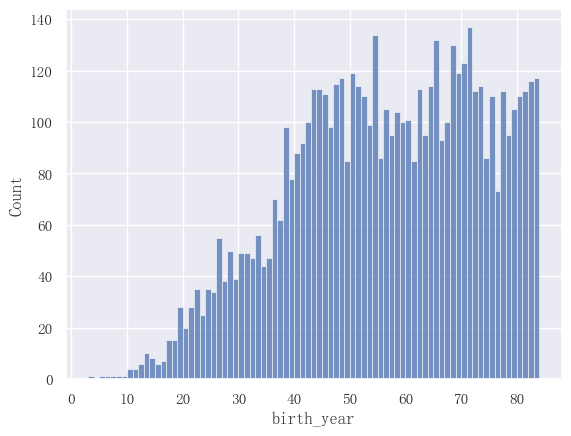

In [28]:
sns.histplot(data_merge["birth_year"], binwidth=1)
plt.show()

### We can see as follows the distribution of political parties by self-identification and vice-versa, self-identification by political party.


In [29]:
df_parties = data_merge[data_merge["political_party"].isin(["DPP", "KMT"])]

[Text(0.5, 0, 'Ethnic Identification')]

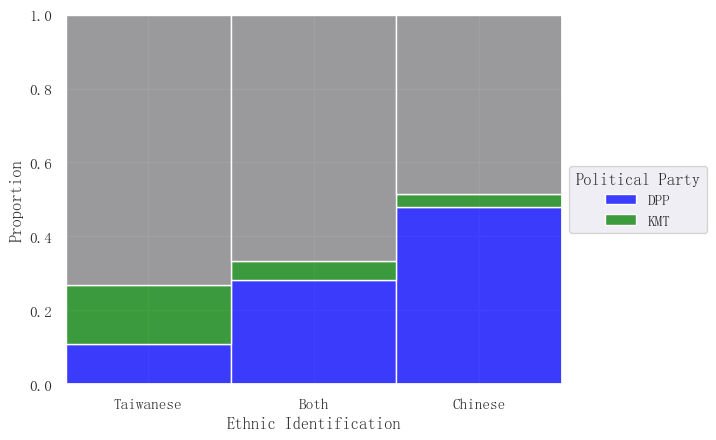

In [30]:
color_palette_parties = {"Other": "gray", "KMT": "blue", "DPP": "green"}

ax = sns.histplot(
    data=data_merge,
    x="taiwanese_or_chinese",
    hue="political_party",
    multiple="fill",
    stat="proportion",
    palette=color_palette_parties,
)

ax.legend(
    title="Political Party",
    labels=df_parties["political_party"].unique(),
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
ax.set(xlabel="Ethnic Identification")

[Text(0.5, 0, 'Political Party')]

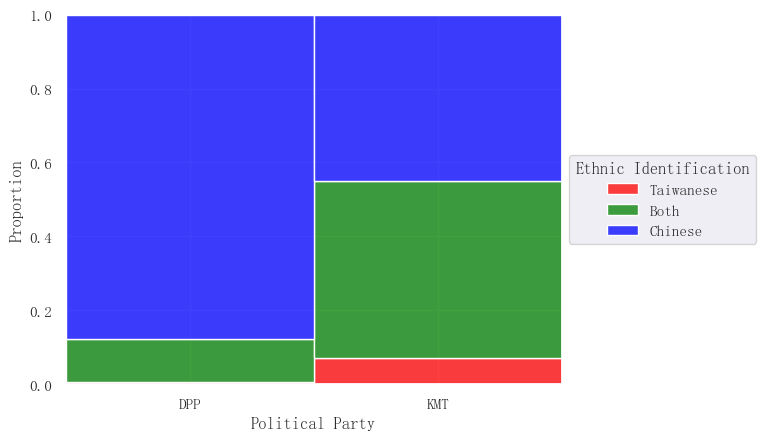

In [31]:
color_palette_ethnic = {"Taiwanese": "blue", "Chinese": "red", "Both": "green"}

ax = sns.histplot(
    data=df_parties,
    x="political_party",
    hue="taiwanese_or_chinese",
    multiple="fill",
    stat="proportion",
    palette=color_palette_ethnic,
)
ax.legend(
    title="Ethnic Identification",
    labels=df_parties["taiwanese_or_chinese"].unique(),
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
ax.set(xlabel="Political Party")

People that identify as Chinese are more probable to vote KMT than other self-identifications.


Although the margin is small, KMT voters tend to have a significantly higher amount of people that self-identify as Chinese.


# Step 3: Machine Learning Classification


In [32]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

### First we must eliminate unimportant values from our target column, such a political_party == 'Other'. This is because 'Other' is a majority class and could imbalance our classification model leading to subpar recall and precision metrics.


### 'Other' is almost four times more sampled than the next biggest category, this majority representation can introduce bias in our model.


In [33]:
data_merge["political_party"].value_counts()

political_party
Other    4081
KMT       969
DPP       720
Name: count, dtype: int64

### The following model shows metrics for prediction when 'Other' is not removed. Observe that party classification models' non-Accuracy metrics are worse than the 'Other' category


In [34]:
# View output of this block directly
# This block is to view metrics of prediction model if 'Other' is not removed

# Split the dataset into features (X) and target variable (y)
X = data_merge.drop(
    columns=["political_party", "year", "religion"]
)  # Drop non-target columns and not needed columns
y = data_merge["political_party"]  # Create target variable

# Create new target variable for each separate target in target column
# i.e This model is able to predict only one target at a time, for example, we can predict if a respondant votes Blue vs Not Blue or Green vs Not Green

y_by_target = pd.get_dummies(y).astype("int")
# The above returns a column by categorical value in 1 or 0 format, such as:
# KMT: [1, 0, 0, 1, 0] DPP:[0, 1, 1, 0, 0] Other: [0, 0, 0, 0, 1]
# Note that together they all fill the original political_party column

# We do the same for the categorical features:
X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=["category"]).columns)

for column in y_by_target.columns:
    # Split the dataset into training and testing sets
    # We will start by predicting affiliation to the KMT
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_by_target[column], test_size=0.2, random_state=42
    )

    # Initialize the Random Forest classifier
    rf_classifier = (
        RandomForestClassifier()
    )  # You can adjust the number of trees (n_estimators) and other hyperparameters

    # Train the classifier on the training data
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf_classifier.predict(X_test)

    # Evaluate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(
        "For the",
        column,
        "predictor model:",
        "\n Accuracy",
        accuracy,
        "\n Recall is:",
        recall,
        "\n F1 Score:",
        f1,
        "\n Precision",
        precision,
        "\n\n",
    )

For the Other predictor model: 
 Accuracy 0.6741767764298093 
 Recall is: 0.8492462311557789 
 F1 Score: 0.7824074074074074 
 Precision 0.7253218884120172 


For the DPP predictor model: 
 Accuracy 0.8596187175043327 
 Recall is: 0.20833333333333334 
 F1 Score: 0.2702702702702703 
 Precision 0.38461538461538464 


For the KMT predictor model: 
 Accuracy 0.8223570190641247 
 Recall is: 0.27102803738317754 
 F1 Score: 0.3613707165109034 
 Precision 0.5420560747663551 




### For the remaining of our modelling, we eliminate this 'Other' category.


In [35]:
data_merge = data_merge[
    data_merge["political_party"] != "Other"
]  # Eliminate the 'other' category

In [36]:
# Split the dataset into features (X) and target variable (y)
X = data_merge.drop(
    columns=["political_party", "year", "religion"]
)  # Drop non-target columns and not needed columns
y = data_merge["political_party"]  # Create target variable

# Create new target variable for each separate target in target column
# i.e This model is able to predict only one target at a time, for example, we can predict if a respondant votes Blue vs Not Blue or Green vs Not Green

y_by_target = pd.get_dummies(y).astype("int")
# The above returns a column by categorical value in 1 or 0 format, such as:
# KMT: [1, 0, 0, 1, 0] DPP:[0, 1, 1, 0, 0] Other: [0, 0, 0, 0, 1]
# Note that together they all fill the original political_party column

# We do the same for the categorical features:
X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=["category"]).columns)

For the DPP predictor model: 
 Accuracy 0.9349112426035503 
 Recall is: 0.903448275862069 
 F1 Score: 0.9225352112676056 
 Precision 0.9424460431654677


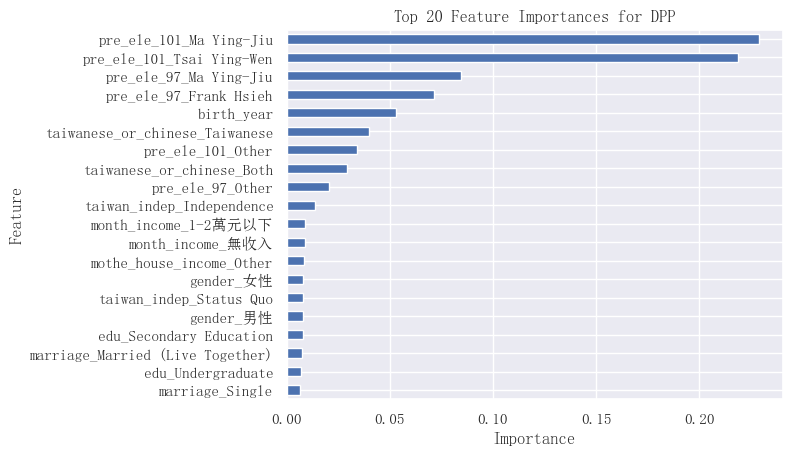

For the KMT predictor model: 
 Accuracy 0.9349112426035503 
 Recall is: 0.9533678756476683 
 F1 Score: 0.9435897435897436 
 Precision 0.934010152284264


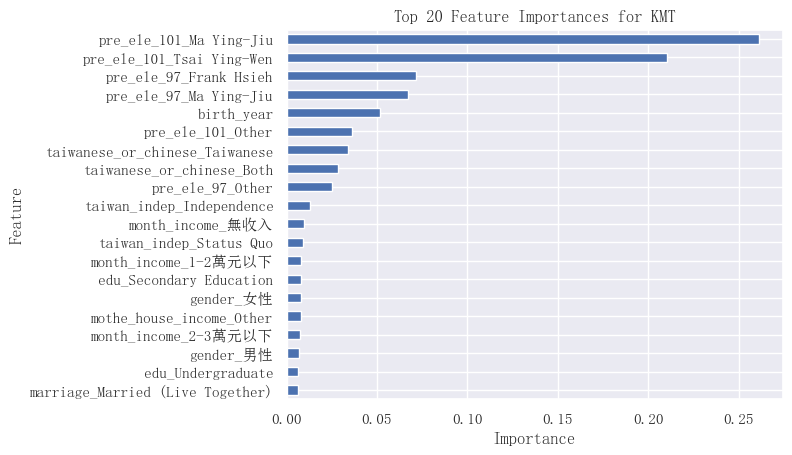

In [37]:
for column in y_by_target.columns:
    if column != "Other":
        # Split the dataset into training and testing sets
        # We will start by predicting affiliation to the KMT
        X_train, X_test, y_train, y_test = train_test_split(
            X_encoded, y_by_target[column], test_size=0.2, random_state=42
        )

        # Initialize the Random Forest classifier
        rf_classifier = (
            RandomForestClassifier()
        )  # You can adjust the number of trees (n_estimators) and other hyperparameters

        # Train the classifier on the training data
        rf_classifier.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf_classifier.predict(X_test)

        # Evaluate the accuracy of the classifier
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        print(
            "For the",
            column,
            "predictor model:",
            "\n Accuracy",
            accuracy,
            "\n Recall is:",
            recall,
            "\n F1 Score:",
            f1,
            "\n Precision",
            precision,
        )

        feat_importances = pd.Series(
            rf_classifier.feature_importances_, index=X_encoded.columns
        )
        ax = feat_importances.nlargest(20).plot(kind="barh")
        ax.invert_yaxis()  # Invert y-axis
        plt.title(f"Top 20 Feature Importances for {column}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()  # Display the plot

Recall, precision and F1 Scores are much improved thanks to target feature simplification


### We can see from above that the most important features are voting preference in the previous election (to the polling date), birth year, ethnic/national identification, and their stance on independence. Most general demographics seem to not be as important to our Random Tree model.


### We can run a logistic regression model isolating each feature and our target to see how the above important features relate with our target. For example, does birth_year relate positively or negatively with our target in each model (i.e Does higher birth_year (younger) result in positive or negative correlation to, say, KMT?)


In [38]:
X.columns

isolated_features = [
    "birth_year",
    "taiwanese_or_chinese",
    "pre_ele_101",
    "pre_ele_97",
    "taiwan_indep",
]

X_isolated_features = pd.DataFrame(X, columns=isolated_features)

X_isolated_features = pd.get_dummies(
    X_isolated_features,
    columns=X_isolated_features.select_dtypes(include=["category"]).columns,
)

In [39]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr

positive_coefficients = []
negative_coefficients = []

for column_y in y_by_target.columns:
    if column_y != "Other":
        for column_X in X_isolated_features.columns:

            current_feature = X_isolated_features[column_X]
            current_target = y_by_target[column_y]

            # Build a simple linear regression model
            model = LogisticRegression()
            model.fit(current_feature.to_frame(), current_target)

            # Print the intercept and coefficient
            # print(f"Intercept: {model.intercept_}")
            # print(f"Coefficient for {column_X} on {column_y}: {model.coef_[0]}  \n")

            if model.coef_[0] > 0.90:
                positive_coefficients.append([column_X, model.coef_[0]])
            elif model.coef_[0] < -0.90:
                negative_coefficients.append([column_X, model.coef_[0]])

        # Print features with positive and negative coefficients
        print(
            f"\n The features with positive correlation with our target {column_y} are:"
        )
        for coef in positive_coefficients:
            print(f"{coef[0]} with coefficient {coef[1]}")

        print(
            f"\n The features with negative correlation with our target {column_y} are:"
        )
        for coef in negative_coefficients:
            print(f"{coef[0]} with coefficient {coef[1]}")

        positive_coefficients = []
        negative_coefficients = []


 The features with positive correlation with our target DPP are:
taiwanese_or_chinese_Taiwanese with coefficient [2.13613732]
pre_ele_101_Tsai Ying-Wen with coefficient [4.93984751]
pre_ele_97_Frank Hsieh with coefficient [4.11903724]
taiwan_indep_Independence with coefficient [1.98987456]

 The features with negative correlation with our target DPP are:
taiwanese_or_chinese_Both with coefficient [-1.91768303]
taiwanese_or_chinese_Chinese with coefficient [-2.01847196]
pre_ele_101_Ma Ying-Jiu with coefficient [-4.82265533]
pre_ele_97_Ma Ying-Jiu with coefficient [-3.25715507]
taiwan_indep_Status Quo with coefficient [-0.98751756]
taiwan_indep_Unification with coefficient [-0.96266257]

 The features with positive correlation with our target KMT are:
taiwanese_or_chinese_Both with coefficient [1.91768303]
taiwanese_or_chinese_Chinese with coefficient [2.01847196]
pre_ele_101_Ma Ying-Jiu with coefficient [4.82265533]
pre_ele_97_Ma Ying-Jiu with coefficient [3.25715507]
taiwan_indep_Stat

### We can see from the above results that the most related predictor of party affiliation is, unsurprisingly, voting history. In this case, voters of Ma Ying-Jiu tend to align themselves more to the KMT, while voters of other candidates and, more strongly, past voters for DPP candidates align themselves with the DPP.

### As well, it can be emphasized almost how much of an effect ethnic/national self-identification has on party alignment. Here people who regard themselves as Taiwanese, in opposition to Chinese or both Taiwanese and Chinese, tend to be positively correlated with DPP alignment. Whereas, people regarding themselves as Chinese or both Taiwanese and Chinese tend to align themselves more with the KMT Party

### Same trend seems to happen for stances on Taiwanese independence. DPP supporters seem to tend more likely to support independence, while KMT supporters prefer unification. It is worth to note that supporting Status Quo on Taiwanese independence seems to be more positively correlated with KMT alignment.
